## Loading the basic libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Loading the machine learning libraries

In [52]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import category_encoders as ce
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

In [3]:
import warnings

In [4]:
warnings.filterwarnings("ignore")

#### Loading the dataset

In [5]:
insurance = pd.read_csv('insurance.csv')

#### creating a copy of the dataset

In [6]:
insurance_original = insurance.copy()

In [7]:
# Viewing the first 3 rows in the dataset
insurance.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [8]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


##### It seems there is no any missing values in the dataset

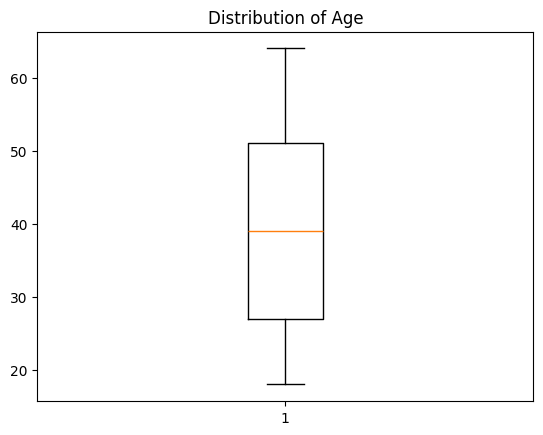

In [9]:
plt.boxplot(insurance.age)
plt.title('Distribution of Age')
plt.show()

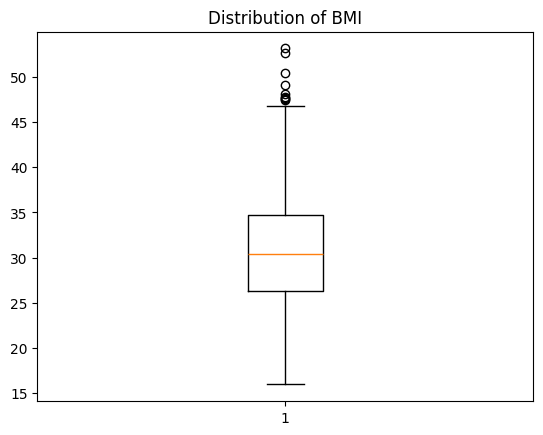

In [10]:
plt.boxplot(insurance.bmi)
plt.title('Distribution of BMI')
plt.show()

In [11]:
column = insurance.bmi
outlier_constant = 1.5
upper_quartile = np.quantile(column,0.75)
lower_quartile = np.quantile(column,0.25)
IQR = (upper_quartile - lower_quartile) * outlier_constant
lower_bound = lower_quartile - IQR
upper_bound = upper_quartile + IQR

In [12]:
#Extracting rows that have outliers
insurance.loc[(insurance.bmi < lower_bound) | (insurance.bmi  > upper_bound),'bmi']

116     49.06
286     48.07
401     47.52
543     47.41
847     50.38
860     47.60
1047    52.58
1088    47.74
1317    53.13
Name: bmi, dtype: float64

In [13]:
#Get the median of the values without the outliers
median = insurance.loc[(insurance['bmi'] >= lower_bound)| (insurance['bmi']  <= upper_bound), 'bmi'].median()
median

np.float64(30.4)

In [14]:
#Replace the outliers with nan values
insurance.loc[(insurance['bmi'] < lower_bound)| (insurance['bmi']  > upper_bound), 'bmi'] = np.nan

In [15]:
#checking if indeed the nan were assigned
insurance.bmi.isnull().sum()

np.int64(9)

In [16]:
#filling in the missing values with the median value
insurance.fillna(median,inplace=True)

In [17]:
#Checking whether we have outliers any outliers
insurance.loc[(insurance.bmi < lower_bound) | (insurance.bmi  > upper_bound),'bmi']

Series([], Name: bmi, dtype: float64)

In [18]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [19]:
#categorical columns to encode
columns_to_encode = ['sex','smoker','region']

In [20]:
#Initialize the one hot encoder
ohe = ce.OneHotEncoder(handle_unknown='ignore',cols = columns_to_encode, use_cat_names=True)
# ohe = OneHotEncoder(sparse_output=False).set_output(transform="pandas")

In [21]:
#Encode the categorical columns
ohe_df = ohe.fit_transform(insurance[columns_to_encode])
ohe_df

,sex_female,sex_male,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast
0,1,0,1,0,1,0,0,0
1,0,1,0,1,0,1,0,0
2,0,1,0,1,0,1,0,0
3,0,1,0,1,0,0,1,0
4,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...
1333,0,1,0,1,0,0,1,0
1334,1,0,0,1,0,0,0,1
1335,1,0,0,1,0,1,0,0
1336,1,0,0,1,1,0,0,0


In [22]:
#Initialize the standard scaler
scaler = StandardScaler().set_output(transform="pandas")

In [23]:
numeric_col = ['age','bmi']

In [24]:
numeric_scaled = scaler.fit_transform(insurance[numeric_col])

In [25]:
numeric_scaled

,age,bmi
0,-1.438764,-0.447019
1,-1.509965,0.548269
2,-0.797954,0.417712
3,-0.441948,-1.327857
4,-0.513149,-0.280855
...,...,...
1333,0.768473,0.073515
1334,-1.509965,0.234592
1335,-1.509965,1.070498
1336,-1.296362,-0.803084


In [26]:
merged_df = pd.concat([numeric_scaled,ohe_df],axis=1)

In [27]:
merged_df.head(3)

,age,bmi,sex_female,sex_male,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast
0,-1.438764,-0.447019,1,0,1,0,1,0,0,0
1,-1.509965,0.548269,0,1,0,1,0,1,0,0
2,-0.797954,0.417712,0,1,0,1,0,1,0,0


In [28]:
#Defining the inputs and outputs
X = merged_df
y = insurance['charges']

In [29]:
#### Spliting the dataset into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=0.20)

In [30]:
# column_trans = ColumnTransformer([('onehot',OneHotEncoder(handle_unknown='ignore'),['sex','smoker','region']),
#                                   ('scaler', StandardScaler(), ['bmi','age'])],
#                                  remainder = 'passthrough',
#                                 force_int_remainder_cols=False)

In [31]:
# Define pipeline
pipe = Pipeline([
    ('regressor', RandomForestRegressor())
   
])

# Define hyperparameters grid
param_grid = [
    # RandomForestRegressor parameters
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 5, 10, 20],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__warm_start':[True,False],
        'regressor__min_samples_split':[2,4,3,5]
    },
    # MLPRegressor parameters
    {
        'regressor':[MLPRegressor(random_state=42)],
        'regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'regressor__activation': ['relu', 'tanh'],
        'regressor__solver': ['adam', 'sgd'],
        'regressor__learning_rate': ['constant', 'adaptive']
    },
    # XGBRegressor parameters
    {
        'regressor':[XGBRegressor(random_state=42)],
        'regressor__n_estimators':[100,150,200,500],
        'regressor__learning_rate':[0.1,0.2,0.001,0.0001,0.5],
        'regressor__max_depth':[3,4,5,6,7,8],
        'regressor__colsample_bytree':[0.8,0.5,0.2,0.3,0.9],
        'regressor__subsample':[0.8,0.7,0.5,0.9]
    }
]

In [47]:
# MLPRegressor?

In [32]:
# Define the model
# mlp = MLPRegressor(max_iter=100)

In [33]:
# Define the parameter grid
# param_grid = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['relu', 'tanh'],
#     'solver': ['adam', 'sgd'],
#     'learning_rate': ['constant', 'adaptive']
# }

In [34]:
# Set up the grid search
# search = RandomizedSearchCV(mlp, param_grid, cv=5)

In [35]:
# Fit the model
# search.fit(X_train, y_train)


In [36]:
# Best parameters
# print(grid_search.best_params_)

In [37]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipe, 
                                 param_grid, 
                                 cv=5, 
                                 scoring='neg_mean_absolute_error', 
                                 n_jobs=-1,
                                 error_score='raise')

In [38]:
# Perform RandomizedSearchCV
random_search.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('regressor',
                                              RandomForestRegressor())]),
                   n_jobs=-1,
                   param_distributions=[{'regressor': [RandomForestRegressor(random_state=42)],
                                         'regressor__max_depth': [None, 5, 10,
                                                                  20],
                                         'regressor__min_samples_split': [2, 4,
                                                                          3,
                                                                          5],
                                         'regressor__n_estimators': [50, 100,
                                                                     200],
                                         'regressor__warm_start': [True,
                                                                   False]}...
                                                                    monotone_constraints=None,
                                                                    multi_strategy=None,
                                                                    n_estimators=None,
                                                                    n_jobs=None,
                                                                    num_parallel_tree=None, ...)],
                                         'regressor__colsample_bytree': [0.8,
                                                                         0.5,
                                                                         0.2,
                                                                         0.3,
                                                                         0.9],
                                         'regressor__learning_rate': [0.1, 0.2,
                                                                      0.001,
                                                                      0.0001,
                                                                      0.5],
                                         'regressor__max_depth': [3, 4, 5, 6, 7,
                                                                  8],
                                         'regressor__n_estimators': [100, 150,
                                                                     200, 500],
                                         'regressor__subsample': [0.8, 0.7, 0.5,
                                                                  0.9]}],
                   scoring='neg_mean_absolute_error')

In [39]:
# best parameters
best_randomsearch_params = random_search.best_params_
best_randomsearch_params

{'regressor__subsample': 0.9,
 'regressor__n_estimators': 500,
 'regressor__max_depth': 5,
 'regressor__learning_rate': 0.1,
 'regressor__colsample_bytree': 0.8,
 'regressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)}

#### best estimator

In [40]:
best_model = random_search.best_estimator_

In [41]:
best_model

Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [42]:
best_model.fit(X_train,y_train)

Pipeline(steps=[('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=5, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [50]:
y_pred = best_model.predict(X_test)

In [53]:
# Calculate r2_score
r2score = r2_score(y_test,y_pred)
r2score

0.8124555027055115

In [54]:
# Calculate mean absolute error
mae = mean_absolute_error(y_test, y_pred)
mae

3207.83115156551

In [55]:
# Calculate mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mse

29116045.303231683

In [43]:
# Retrain the MLP model with the best parameters
ml = XGBRegressor(**best_randomsearch_params)

In [44]:
ml.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [45]:
random_search.best_score_

np.float64(-3465.811672655031)